# Front pages of newspapers -- Initial discovery

We have two datasets:
* `frontpage_texts`, the text boxes extracted from pdfs of the front pages of newspapers, downloaded from the [Newseum](https://newseum.org/todaysfrontpages/)
* `newspapers`, the metadata of the newspapers, also from the Newseum site.

The text boxes contain interesting metadata for a given chunk of text, such as its bounding box, font, and size.

This notebook will document some of the early exploratory attempts to understand the variety of the data, and to move toward performing an analysis of media coverage/bias.

In [1]:
import pandas as pd

df = pd.read_sql_table('frontpage_texts', 'postgres:///frontpages')

In [2]:
df.head()

,text,fontface,fontsize,bbox_left,bbox_bottom,bbox_right,bbox_top,bbox_area,avg_character_area,percent_of_page,page,page_width,page_height,page_area,date,day_of_week,weekend,slug,id
0,CHEYENNE – Education and \nunderstanding are c...,UYJQTF+Dutch811BT-RomanD,11.894,355.199,565.665,495.693,814.413,34947.601512,53.988159,0.030769,1,788.76,1440.0,1135814.4,2017-04-09,6,True,WY_WTE,146016
1,For more information\n,IGKWHD+GriffithGothicCond-Ultra,18.224,508.720,892.167,635.040,910.391,2302.055680,120.001395,0.002027,1,788.76,1440.0,1135814.4,2017-04-09,6,True,WY_WTE,146017
2,To learn more about the courthouse \nexpansion...,HCVQTF+GriffithGothic-Bold,9.758,508.720,825.022,637.342,885.185,7738.285386,35.217527,0.006813,1,788.76,1440.0,1135814.4,2017-04-09,6,True,WY_WTE,146018
3,"There, you can read descriptions of all \n44 p...",HCVQTF+GriffithGothic-Bold,9.758,508.720,798.859,637.929,818.698,2563.377351,33.936823,0.002257,1,788.76,1440.0,1135814.4,2017-04-09,6,True,WY_WTE,146019
4,raising $18 million to provide ad-\nditional s...,UYJQTF+Dutch811BT-RomanD,11.894,502.718,565.874,641.321,787.481,30715.395021,55.198782,0.027043,1,788.76,1440.0,1135814.4,2017-04-09,6,True,WY_WTE,146020


In [3]:
# Some simple cleaning -- remove one character entries, and trailing newlines

df['text'] = df['text'].str.strip()
df = df[df['text'].str.len() > 1]

In [4]:
df_newspapers = pd.read_sql_table('newspapers', 'postgres:///frontpages')

In [5]:
df_newspapers.head()

,city,country,latitude,longitude,slug,state,title,website
0,Anniston,USA,33.696739,-85.823433,AL_AS,AL,The Anniston Star,http://www.annistonstar.com
1,Birmingham,USA,33.518509,-86.804756,AL_BN,AL,The Birmingham News,http://www.al.com/birmingham/
2,Cullman,USA,34.176857,-86.838188,AL_CT,AL,The Cullman Times,http://www.cullmantimes.com
3,Decatur,USA,34.602890,-86.986511,AL_DD,AL,The Decatur Daily,http://www.decaturdaily.com
4,Dothan,USA,31.225517,-85.393631,AL_DE,AL,Dothan Eagle,http://www.dothaneagle.com


In [6]:
us_newspapers_df = df_newspapers[df_newspapers.country == 'USA']
print('''We have metadata for {} newspapers.

There are {} total countries represented. The top 5 are:
{}.

Within the US, there is representation from {} states. The states with the most newspapers are:
{}

And the least:
{}

'''.format(
    df_newspapers.shape[0],
    df_newspapers.country.nunique(),
    df_newspapers.country.value_counts()[:5],
    us_newspapers_df.state.nunique(),
    us_newspapers_df.state.value_counts()[:5],
    us_newspapers_df.state.value_counts()[-5:],
))

We have metadata for 1020 newspapers.

There are 79 total countries represented. The top 5 are:
USA       679
Brazil     59
Canada     36
India      21
Mexico     19
Name: country, dtype: int64.

Within the US, there is representation from 51 states. The states with the most newspapers are:
NY    55
CA    52
PA    44
FL    33
TX    28
Name: state, dtype: int64

And the least:
RI    3
NV    3
ND    3
DE    2
HI    1
Name: state, dtype: int64




In [7]:
df_us = df[df.slug.isin(set(us_newspapers_df.slug))]
newspapers_in_df = df_newspapers[df_newspapers.slug.isin(set(df_us.slug))]

print('''Currently, there are:

{} rows of text
{} days of scrapes
  (earliest: {} 
   latest  : {})
{} total newspapers (not all the pdfs were extractable).

Filtering down to the US, there are now:
{} newspapers
{} rows of text

For those newspapers that are available in the US, there are:
{} states
states with most newspapers:
{}

with least:
{}

with none:
{}
'''.format(
    df.shape[0],
    df.date.nunique(),
    df.date.min(),
    df.date.max(),
    df.slug.nunique(),

    df_us.slug.nunique(),
    df_us.shape[0],
    
    newspapers_in_df.state.nunique(),
    newspapers_in_df.state.value_counts()[:5],
    newspapers_in_df.state.value_counts()[-5:],
    set(df_newspapers.state) - set(newspapers_in_df.state)
))

Currently, there are:

138881 rows of text
7 days of scrapes
  (earliest: 2017-04-01 00:00:00 
   latest  : 2017-04-09 00:00:00)
570 total newspapers (not all the pdfs were extractable).

Filtering down to the US, there are now:
378 newspapers
97143 rows of text

For those newspapers that are available in the US, there are:
49 states
states with most newspapers:
CA    23
PA    22
IN    19
TX    19
NY    16
Name: state, dtype: int64

with least:
RI    2
DE    2
NV    1
AK    1
NE    1
Name: state, dtype: int64

with none:
{'', 'HI', 'NH'}



# Fonts

In [8]:
print('''Fonts are often written in a format like this: {}.

Out of {} rows...
{} of the fonts have non-empty text
{} of the fonts have a '+'
{} of the fonts have a '-'
'''.format(
    df.fontface.iloc[0],
    df.shape[0],
    (df.fontface.str.len() > 0).sum(),
    df.fontface.str.contains('\+').sum(),
    df.fontface.str.contains('-').sum()
))

Fonts are often written in a format like this: UYJQTF+Dutch811BT-RomanD.

Out of 138881 rows...
138881 of the fonts have non-empty text
97306 of the fonts have a '+'
120875 of the fonts have a '-'



In [31]:
df_us = df[df.slug.isin(set(us_newspapers_df.slug))]

print('''This seems to mean that we can break apart the font into:
[optional-leading-thing]+[font-family]-[font-weight]
''')

font_partition = df.fontface.str.rpartition('+')
df['font_family_weight'] = font_partition[2]

font_family_partition = df['font_family_weight'].str.partition('-')

df['font_leading_thing'] = font_partition[0]
df['font_family'] = font_family_partition[0]
df['font_weight'] = font_family_partition[2]

print('''After doing that,
There are...
{} unique font families
{} unique font weights
{} unique optional-leading-things'''.format(
    df.font_family.nunique(),
    df.font_weight.nunique(),
    df.font_leading_thing.nunique()
))

This seems to mean that we can break apart the font into:
[optional-leading-thing]+[font-family]-[font-weight]

After doing that,
There are...
1640 unique font families
1162 unique font weights
16959 unique optional-leading-things


# Denver Post

In [10]:
# Let's do something with a Denver paper

df_newspapers[df_newspapers.city == 'Denver']

,city,country,latitude,longitude,slug,state,title,website
64,Denver,USA,39.741684,-104.987366,CO_DP,CO,The Denver Post,http://www.denverpost.com


In [32]:
import numpy as np

df_denver_post = df_us[df_us.slug == 'CO_DP']

font_stats = df_denver_post.groupby(['font_family_weight']).fontsize.agg({'count': len, 'min': np.min, 'max': np.max, 'avg': np.mean})

print('''We have {} days of scraped Denver Post front pages.

We have {} unique font-weight combos. Here is a mapping of each font family to their min, average, and max font size.

{}
'''.format(
    df_denver_post.date.nunique(),
    df_denver_post.groupby(['font_family_weight']).first().shape[0],
    font_stats
))

We have 7 days of scraped Denver Post front pages.

We have 47 unique font-weight combos. Here is a mapping of each font family to their min, average, and max font size.

                                count     min      max        avg
font_family_weight                                               
Agenda-Bold                       1.0  31.870   31.870  31.870000
AkzidenzGroteskBE-LightEx         1.0   4.354    4.354   4.354000
AkzidenzGroteskBE-MdEx            2.0   6.244   13.537   9.890500
Arial-Black                       1.0  26.410   26.410  26.410000
Arial-BoldItalicMT                1.0   9.469    9.469   9.469000
Avenir-Heavy                      3.0   4.853    4.853   4.853000
AzoSansUber-Regular               2.0  19.680   24.928  22.304000
CastleT-Ultr                      1.0  39.039   39.039  39.039000
DPPiFont                          4.0   8.504    8.504   8.504000
Gotham-Thin                       1.0   8.839    8.839   8.839000
MyriadPro-Bold                    2.0

In [12]:
font_days = df_denver_post.groupby(['font_family_weight']).date.nunique().sort_values(ascending=False)

print('''Fonts by number of days on which they appear

{}
'''.format(
    font_days
))

Fonts by number of days on which they appear

font_family_weight
PoynterOSDisplayNarrow-Bold       7
SunSC-Regular                     7
PoynterOSDisplay-Italic           7
PoynterOSDisplayNarrow-Semibld    7
PoynterOSTextThree-Bold           7
PoynterOSTextThree-Roman          7
Sun-SemiBold                      7
SunSC-ExtraBold                   7
Sun-Bold                          7
TheSerifLight-Plain               6
PoynterOSTextThree-Italic         6
PoynterOSDisplay-Roman            6
PoynterOSDisplay-Bold             5
PoynterOSTextThree-SemiBld        5
DPPiFont                          4
SunSC-Bold                        4
TheSerifExtraBold-Plain           3
MyriadPro-Regular                 3
PoynterOSDisplay-Semibold         3
SunSC-SemiBold                    2
MyriadPro-It                      2
MyriadPro-BoldIt                  2
MyriadPro-Bold                    2
MyriadPro-SemiboldIt              2
Sun-ExtraBold                     2
AzoSansUber-Regular               2

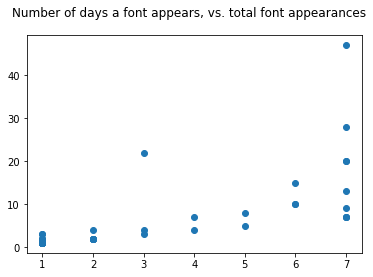

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt

font_stats['days_present'] = font_days

plt.suptitle('Number of days a font appears, vs. total font appearances')
plt.scatter(font_stats.days_present, font_stats['count'])

In [33]:
df_denver_post.sort_values(['date', 'avg_character_area'], ascending=False).groupby('date').head(5)

,text,fontface,fontsize,bbox_left,bbox_bottom,bbox_right,bbox_top,bbox_area,avg_character_area,percent_of_page,...,page_area,date,day_of_week,weekend,slug,id,font_family_weight,font_leading_thing,font_family,font_weight
132237,Train sidetracked\nby costly problems,LJJAKB+PoynterOSDisplayNarrow-Bold,76.976,192.460,1039.602,699.747,1180.566,71509.204668,2357.592062,0.064946,...,1101056.0,2017-04-09,6,True,CO_DP,132204,PoynterOSDisplayNarrow-Bold,LJJAKB,PoynterOSDisplayNarrow,Bold
132218,PIONEERS WIN 8TH NCAA\nHOCKEY CHAMPIONSHIP» 1C,LJJAJA+Sun-SemiBold,34.432,212.250,1374.810,531.637,1439.242,20578.743184,559.303913,0.018690,...,1101056.0,2017-04-09,6,True,CO_DP,132185,Sun-SemiBold,LJJAJA,Sun,SemiBold
132226,Fresh strike\non town hit\nby deadly\nchemicals,LJJCDM+PoynterOSDisplayNarrow-Semibld,33.540,18.000,1053.800,151.800,1177.340,16529.652000,439.926957,0.015013,...,1101056.0,2017-04-09,6,True,CO_DP,132193,PoynterOSDisplayNarrow-Semibld,LJJCDM,PoynterOSDisplayNarrow,Semibld
132236,A-Line Anniversary,LJJAJO+TheSerifExtraBold-Plain,29.466,192.460,1169.370,356.042,1198.836,4820.107212,279.140084,0.004378,...,1101056.0,2017-04-09,6,True,CO_DP,132203,TheSerifExtraBold-Plain,LJJAJO,TheSerifExtraBold,Plain
132214,M EM B E R S,LJJAJF+TheSerifLight-Plain,22.232,35.400,1440.360,104.252,1462.592,1530.717664,202.666912,0.001390,...,1101056.0,2017-04-09,6,True,CO_DP,132181,TheSerifLight-Plain,LJJAJF,TheSerifLight,Plain
114490,SPRING Patio,JKOADO+Veneer,71.978,46.262,132.522,341.105,204.500,21222.209454,1879.195081,0.019274,...,1101056.0,2017-04-08,5,True,CO_DP,114457,Veneer,JKOADO,Veneer,
114269,Strike on SyriaU.S. to keep pressure on,JKNLLB+PoynterOSDisplayNarrow-Bold,84.900,18.000,1171.500,720.653,1265.786,66250.340758,1837.647666,0.060170,...,1101056.0,2017-04-08,5,True,CO_DP,114236,PoynterOSDisplayNarrow-Bold,JKNLLB,PoynterOSDisplayNarrow,Bold
114287,VERY SOUND ON THE MOUND,JKNODC+PoynterOSDisplay-Semibold,40.572,43.000,922.180,564.917,962.752,21175.216524,1062.388497,0.019232,...,1101056.0,2017-04-08,5,True,CO_DP,114254,PoynterOSDisplay-Semibold,JKNODC,PoynterOSDisplay,Semibold
114489,ANNUAL,JKOADO+Veneer,43.472,139.397,182.322,247.974,225.794,4720.059344,760.433960,0.004287,...,1101056.0,2017-04-08,5,True,CO_DP,114456,Veneer,JKOADO,Veneer,
114491,CLEARANCE SALE,JKOADO+Veneer,43.472,82.192,99.522,305.161,142.994,9692.908368,718.090560,0.008803,...,1101056.0,2017-04-08,5,True,CO_DP,114458,Veneer,JKOADO,Veneer,


# Unigram "percent of page" analysis

Given an unigram like "Syria", how much of a given front page does it occupy? 

### Notes

We will consider the entire text block that contains the unigram to be related to that unigram. For example, the entire headline of "US BOMBS SYRIA" will be counted as space devoted toward "Syria". Likewise, a lengthy front-page article that mentions "Syria" in it will (naively, perhaps) be considered 100% about Syria.

We're assuming that search queries will be proper nouns, so we're not going to perform any stemming or lemmatizing.

### Followup approaches

Some newspapers contain more and smaller text, like the NYT, compared to tabloids where words are written extremely largely across the surface. This may still be of interest -- we do want to acknowledge the space devoted to "Syria" if it is splashed across the front of the tabloid -- but we may also want to develop a measure of relative importance so that a top-of-banner headline is weighted equally across all newspapers.

This approach does not touch on probabilistic topic modeling yet -- these are only direct matches.

We will also want to develop a method to link a headline with an article, so that a headline like "BOOTS ON THE GROUND" could possibly be linked to the followup article on Syria. This would also allow us to do some tangential but interesting accounts of which Associated Press articles get republished the most.

In [17]:
from nltk import word_tokenize

In [24]:
import pprint

def preprocess_text(text):
    lowered = text.strip().lower()
    lowered = ''.join(lowered.split('-\n'))
    lowered = lowered.replace('\n', ' ')
    
    return word_tokenize(lowered)

def bag_of_words(text):
    '''Literally, this returns a set of the bag of words for fast single-token searches'''
    return set(preprocess_text(text))

def preprocess_all(texts):
    for text in texts:
        yield text, preprocess_text(text)

print('''For text preprocessing, we consider a few cases:

* Newlines should be stripped
* Everything should be lower-cased
* We should return a tokenized list

The extraction from PDFs still contains word-continuations across line breaks.
For now, we'll consider all lines that end with "-" as continuations, and
link the text from before and after.

Newlines without continuations will be replaced with spaces.

Examples:
{}
'''.format(
    pprint.pformat(list(preprocess_all([
        'Hel-\nlo, bye\nnow\n',
         *df_denver_post.text.sample(3)
    ])))
))

For text preprocessing, we consider a few cases:

* Newlines should be stripped
* Everything should be lower-cased
* We should return a tokenized list

The extraction from PDFs still contains word-continuations across line breaks.
For now, we'll consider all lines that end with "-" as continuations, and
link the text from before and after.

Newlines without continuations will be replaced with spaces.

Examples:
[('Hel-\nlo, bye\nnow\n', ['hello', ',', 'bye', 'now']),
 ('ROCKIES » 6A', ['rockies', '»', '6a']),
 ('Kara Goucher straightens framed magazine covers of herself at her home near '
  'Boulder. Goucher is being inducted into the',
  ['kara',
   'goucher',
   'straightens',
   'framed',
   'magazine',
   'covers',
   'of',
   'herself',
   'at',
   'her',
   'home',
   'near',
   'boulder',
   '.',
   'goucher',
   'is',
   'being',
   'inducted',
   'into',
   'the']),
 ('SYRIA » 4A', ['syria', '»', '4a'])]



In [35]:
df_us['bow'] = df_us.text.apply(bag_of_words)

/Users/sam/workspace/news/analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
df_denver_post_latest = df_us[(df_us.slug == 'CO_DP') & (df_us.date == df_us.date.max())]

def percent_of_page(unigram, one_paper_df):
    unigram = unigram.lower().strip()
    lines_with_unigram = one_paper_df[one_paper_df.bow.apply(lambda bag: unigram in bag)]
    
    return lines_with_unigram.percent_of_page.sum()

print('''Now we write a method to get the percent of page that a unigram occupies, for a particular front page.

Syria, Denver Post, latest day: {}
garbage input, should be 0: {}'''.format(
    percent_of_page('Syria', df_denver_post_latest),
    percent_of_page('asdflkjasdflasdfkjasdf', df_denver_post_latest)
))

Now we write a method to get the percent of page that a unigram occupies, for a particular front page.

Syria, Denver Post, latest day: 0.050328424026570825
garbage input, should be 0: 0


Now we run this method across all the newspapers, across all days!

In [73]:
# filter down to newspapers with entries with more than 3 days
days_of_newspapers = df_us.groupby('slug').date.nunique()

df_us_3plus = df_us[df_us.slug.isin(set(days_of_newspapers[days_of_newspapers > 3].index))]

print('''Number of newspapers with >3 days: {}

(Number of total newspapers: {})
'''.format(
    df_us_3plus.slug.nunique(),
    df_us.slug.nunique()
))

Number of newspapers with >3 days: 277

(Number of total newspapers: 378)



In [92]:
from functools import partial

def unigram_percent_of_page(query, dataframe):
    return dataframe.groupby(['slug', 'date']).apply(partial(percent_of_page, query))

def _reshape_percent_of_day_series(percent_of_page):
    return percent_of_page.reset_index().rename(columns={0: 'percent_of_page'})

def percent_of_page_by_day(percent_of_page_df):
    return _reshape_percent_of_day_series(percent_of_page_df).groupby('date').percent_of_page.mean()

def percent_of_papers_with_mention(percent_of_page_df, threshold=0):
    percents_by_paper_date = _reshape_percent_of_day_series(percent_of_page_df)
    greater_than_thresh = (percents_by_paper_date.groupby(['slug', 'date']).percent_of_page.max() > threshold).reset_index()
    
    return greater_than_thresh.groupby('date').mean()

In [ ]:
# Average mentions per day
syria_results = unigram_percent_of_page('Syria', df_us_3plus)

In [189]:
print('''Percent of papers that mentioned Syria by day:
{}

Average percent of newspaper front page devoted to Syria by day:
{}'''.format(
    percent_of_papers_with_mention(syria_results),
    percent_of_page_by_day(syria_results),
))

Percent of papers that mentioned Syria by day:
            percent_of_page
date                       
2017-04-01         0.020080
2017-04-04         0.017621
2017-04-05         0.228000
2017-04-06         0.294355
2017-04-07         0.608696
2017-04-08         0.592105
2017-04-09         0.280374

Average percent of newspaper front page devoted to Syria by day:
date
2017-04-01    0.000634
2017-04-04    0.000548
2017-04-05    0.005099
2017-04-06    0.009075
2017-04-07    0.028223
2017-04-08    0.031987
2017-04-09    0.010390
Name: percent_of_page, dtype: float64


# Connecting newspapers with population metadata

Short of getting data on readership, we'll try to pull population metadata for the hometown of each newspaper.

Edit: See bottom for conclusion. Tldr: it's not great, because there are multiple papers per city, many of which are lesser read. Doh.

In [96]:
df_population = pd.read_csv('~/data/sub-est2015_all.csv', encoding='ISO-8859-2')

In [150]:
df_cities = df_population[df_population.NAME.str.endswith('city') | df_population.NAME.str.endswith('town')]
df_cities['city'] = df_cities.NAME.str.slice(0, -5).str.lower()
df_cities['place_name'] = df_cities.city + ', ' + df_cities.STNAME.str.lower()

df_cities = df_cities.sort_values('POPESTIMATE2015').groupby('place_name').head(1)
df_cities.head()

/Users/sam/workspace/news/analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sam/workspace/news/analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,city,place_name
35950,61,27,103,0,39878,0,0,F,Mankato city,Minnesota,0,0,0,0,0,0,0,0,mankato,"mankato, minnesota"
40886,157,29,137,28000,0,0,1,A,Goss town,Missouri,0,0,0,0,0,0,0,0,goss,"goss, missouri"
81136,61,55,133,0,53000,0,0,F,Milwaukee city,Wisconsin,0,0,0,0,0,0,0,0,milwaukee,"milwaukee, wisconsin"
44352,61,33,9,0,42820,0,1,I,Livermore town,New Hampshire,0,0,0,0,0,0,0,0,livermore,"livermore, new hampshire"
23257,61,20,91,0,7975,0,0,F,Bonner Springs city,Kansas,0,0,0,0,0,0,0,0,bonner springs,"bonner springs, kansas"


In [119]:
state_abbreviation_to_name = {}
with open('files/states.csv') as f:
    next(f) # skip header
    for line in f:
        state, abbrev = line.strip().split(',')
        state_abbreviation_to_name[abbrev.strip('"')] = state.strip('"').lower()

In [121]:
us_newspapers_df['place_name'] = us_newspapers_df.city.str.lower() + ', ' + us_newspapers_df.state.apply(state_abbreviation_to_name.get)

/Users/sam/workspace/news/analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/sam/workspace/news/analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [151]:
us_newspapers_with_pop = pd.merge(us_newspapers_df, df_cities[['place_name', 'POPESTIMATE2015']], how='left', on='place_name', copy=False)

In [152]:
print('''{} out of {} newspapers had places found in the census.

Examples of ones that didn't:
{}
'''.format(
    us_newspapers_with_pop.POPESTIMATE2015.count(),
    us_newspapers_with_pop.shape[0],
    us_newspapers_with_pop[us_newspapers_with_pop.POPESTIMATE2015.isnull()].place_name.head()
))

608 out of 679 newspapers had places found in the census.

Examples of ones that didn't:
15            juneau, alaska
56       ventura, california
106    the villages, florida
111         augusta, georgia
118           macon, georgia
Name: place_name, dtype: object



In [160]:
us_newspapers_df.head()

,city,country,latitude,longitude,slug,state,title,website,state_name,place_name
0,Anniston,USA,33.696739,-85.823433,AL_AS,AL,The Anniston Star,http://www.annistonstar.com,Alabama,"anniston, alabama"
1,Birmingham,USA,33.518509,-86.804756,AL_BN,AL,The Birmingham News,http://www.al.com/birmingham/,Alabama,"birmingham, alabama"
2,Cullman,USA,34.176857,-86.838188,AL_CT,AL,The Cullman Times,http://www.cullmantimes.com,Alabama,"cullman, alabama"
3,Decatur,USA,34.602890,-86.986511,AL_DD,AL,The Decatur Daily,http://www.decaturdaily.com,Alabama,"decatur, alabama"
4,Dothan,USA,31.225517,-85.393631,AL_DE,AL,Dothan Eagle,http://www.dothaneagle.com,Alabama,"dothan, alabama"


In [172]:
unidentified_map = {}

unidentified_places = us_newspapers_with_pop[us_newspapers_with_pop.POPESTIMATE2015.isnull()]

for i, row in unidentified_places.iterrows():
    matches = (df_population.STNAME == row.state_name) & (df_population.NAME.str.lower().str.contains(row.city.lower()))
    if matches.sum() == 0:
        continue
        
    pops = df_population[matches].sort_values('POPESTIMATE2015').iloc[0]
    unidentified_map[row.place_name] = (pops.NAME, pops.POPESTIMATE2015)

In [173]:
print('''Out of {} unidentified places, we found {} by looking for substrings.'''.format(
    unidentified_places.shape[0],
    len(unidentified_map)
))

Out of 71 unidentified places, we found 43 by looking for substrings.


Good enough!

In [188]:
import numpy as np

def set_from_map_if_null(row):
    if pd.isnull(row.POPESTIMATE2015):
        return unidentified_map.get(row.place_name, [np.nan, np.nan])[1]
    
    return row.POPESTIMATE2015

us_newspapers_with_pop['population_est_2015'] = us_newspapers_with_pop.apply(set_from_map_if_null, 1)

print('''So now {} out of {} newspapers have populations.

Largest newspapers by population:
{}
'''.format(
    us_newspapers_with_pop.population_est_2015.count(),
    us_newspapers_with_pop.shape[0],
    us_newspapers_with_pop.sort_values('population_est_2015', ascending=False).head(5)[['title', 'state']]
))

So now 653 out of 679 newspapers have populations.

Largest newspapers by population:
                                         title state
529  The Epoch Times: Chinese New York Edition    NY
292                                 Daily News    NY
530                    The Wall Street Journal    NY
617                   Metro - New York Edition    NY
667                         Impacto Latin News    NY



Oof. Looks like population might not work so well, since large cities often have several, lesser-read newspapers.